## imports

In [39]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


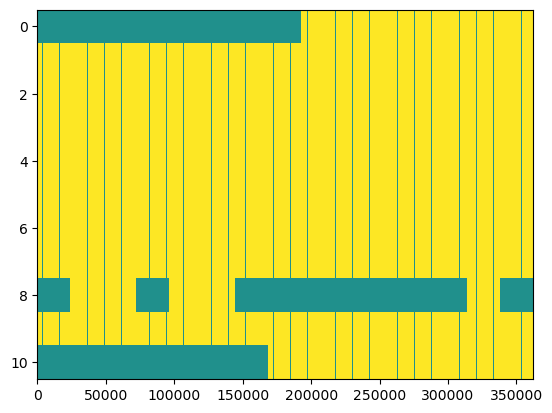

In [40]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## NIM

In [41]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 11])
      bias: torch.Size([11])


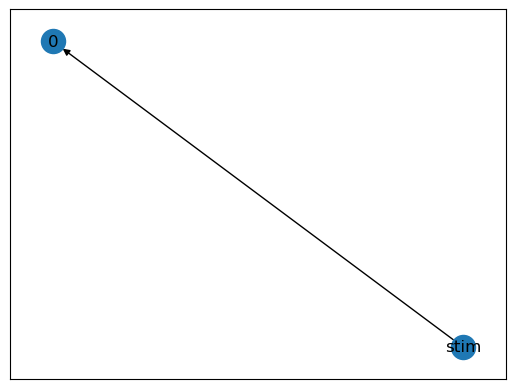

In [42]:
## Shared NIM
num_subs = 8
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, 
    norm_type=0,
    NLtype='softplus', 
    bias=True, 
    initialize_center = True)

nim_all = NDN.NDN( layer_list=[sub_par, readout_par] )

m.draw_model(nim_all)

nim_all.list_parameters()

In [50]:
# nim_all.fit(data, **adam_pars, verbose=2)
# LLs1 = nim_all.eval_models(data[data.val_inds], null_adjusted=True)
# print(LLs1)
# print(np.mean(LLs1))
# 

# with open('nim1.pickle', 'wb') as f:
#    pickle.dump(nim_all, f)
with open('nim1.pickle', 'rb') as f:
    nim_all = pickle.load(f)

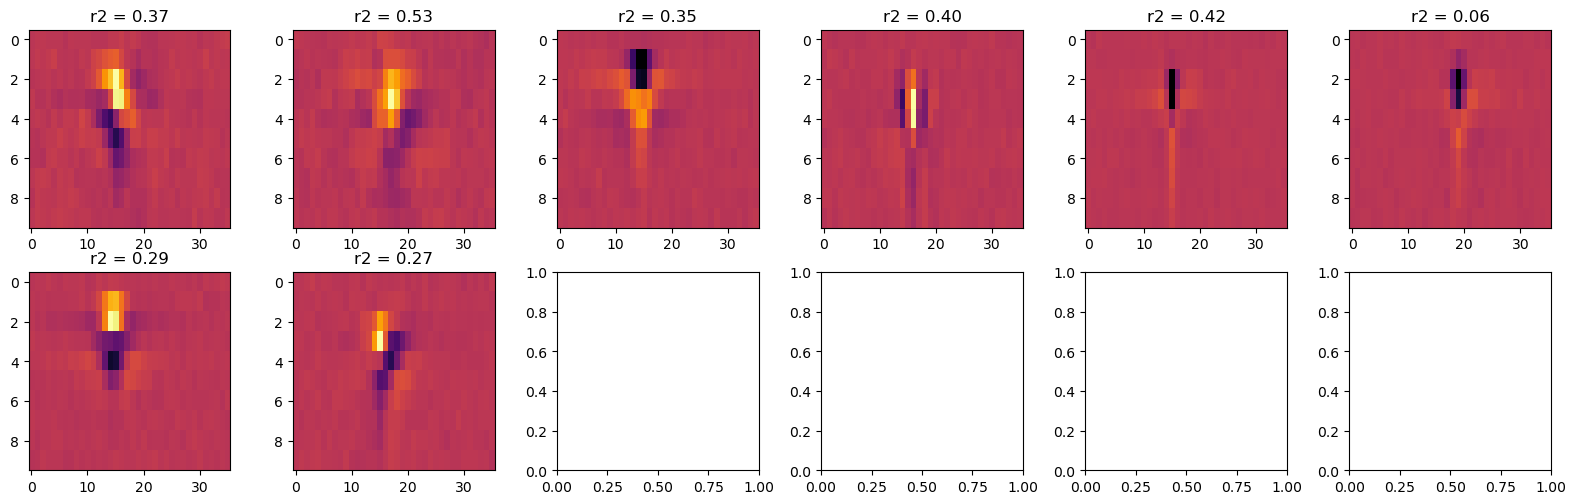

In [51]:
glm_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 6, c+1)
    imagesc(nim_all.networks[0].layers[0].get_weights()[:,:,c], cmap='inferno')
    plt.title('r2 = ' + glm_r2s[c])
plt.show()

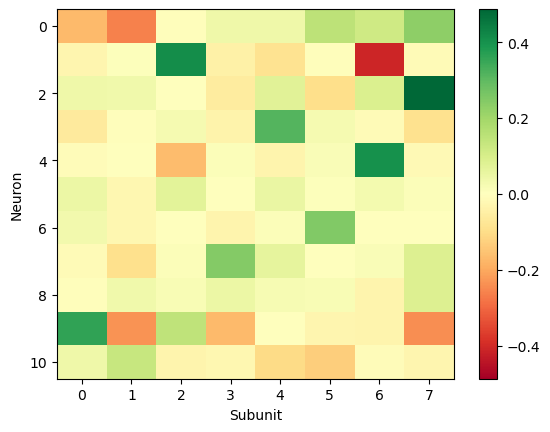

In [45]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='RdYlGn')
plt.xlabel('Subunit')
plt.ylabel('Neuron')
plt.colorbar()
plt.show()

### plot the filter as the weighted sum of one of the neurons 

In [46]:
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.get_weights(layer_target=1)
hidden.shape, output.shape

((36, 10, 8), (8, 11))

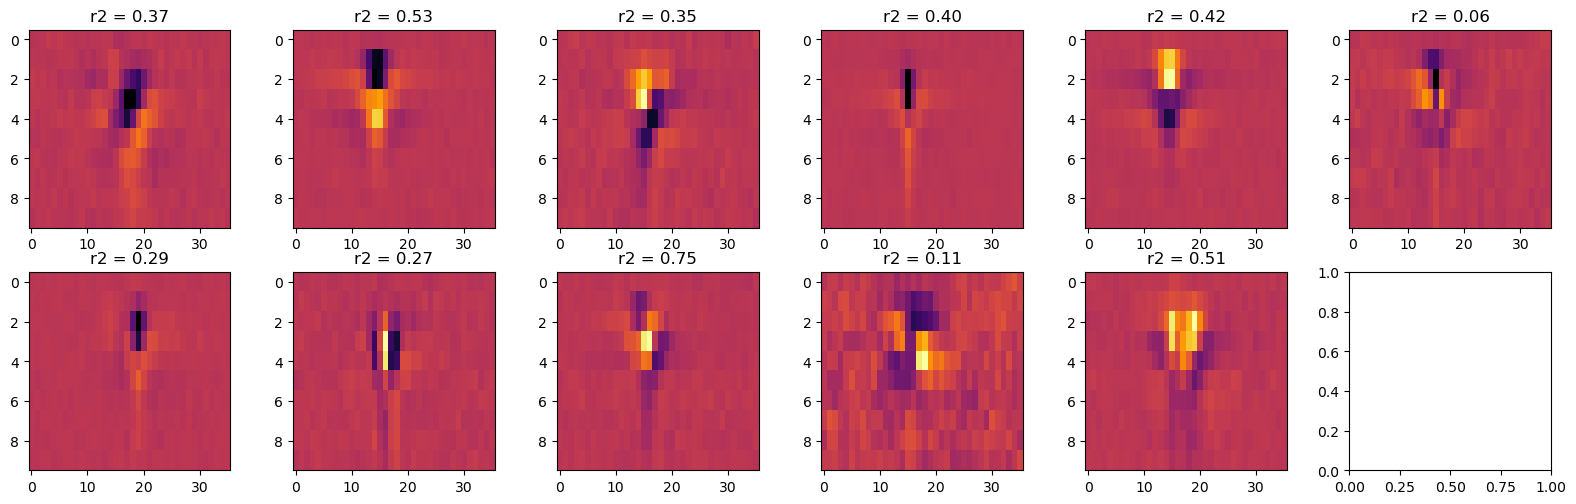

In [47]:
nim_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot cell weighted filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    plt.imshow(rfield, cmap='inferno', aspect='auto', vmin=imin, vmax=imax)
    plt.title('r2 = ' + nim_r2s[c])
plt.show()

### all data on GPU

In [48]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [49]:
## About 2x speedup
nim_all = NDN.NDN( layer_list=[sub_par, readout_par])
nim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(val_ds, null_adjusted=True)
print(LLs1, np.mean(LLs1))


GPU Available: True, GPU Used: True


Epoch 2:  36%|████████▉                | 49/138 [00:00<00:01, 59.22it/s, train_loss=0.417]


Done fitting
  Fit complete: 3.6697678565979004 sec elapsed


Eval models: 100%|███████████████████████████████████████| 69/69 [00:00<00:00, 135.03it/s]

[ 0.10983849  0.503729    0.49131513  0.21162581  0.42771423 -0.07446861
  0.04871798 -0.02332664 -0.7025938   0.04044819 -0.20070434] 0.07566322


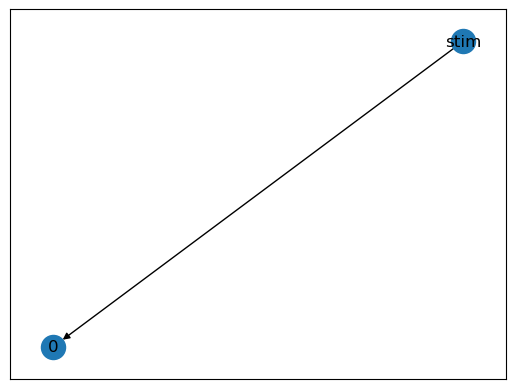

In [15]:
m.draw_model(nim_all)

In [16]:
nim_all.networks[0].layers[0](data.stim).shape

torch.Size([362504, 8])

<Figure size 640x480 with 0 Axes>

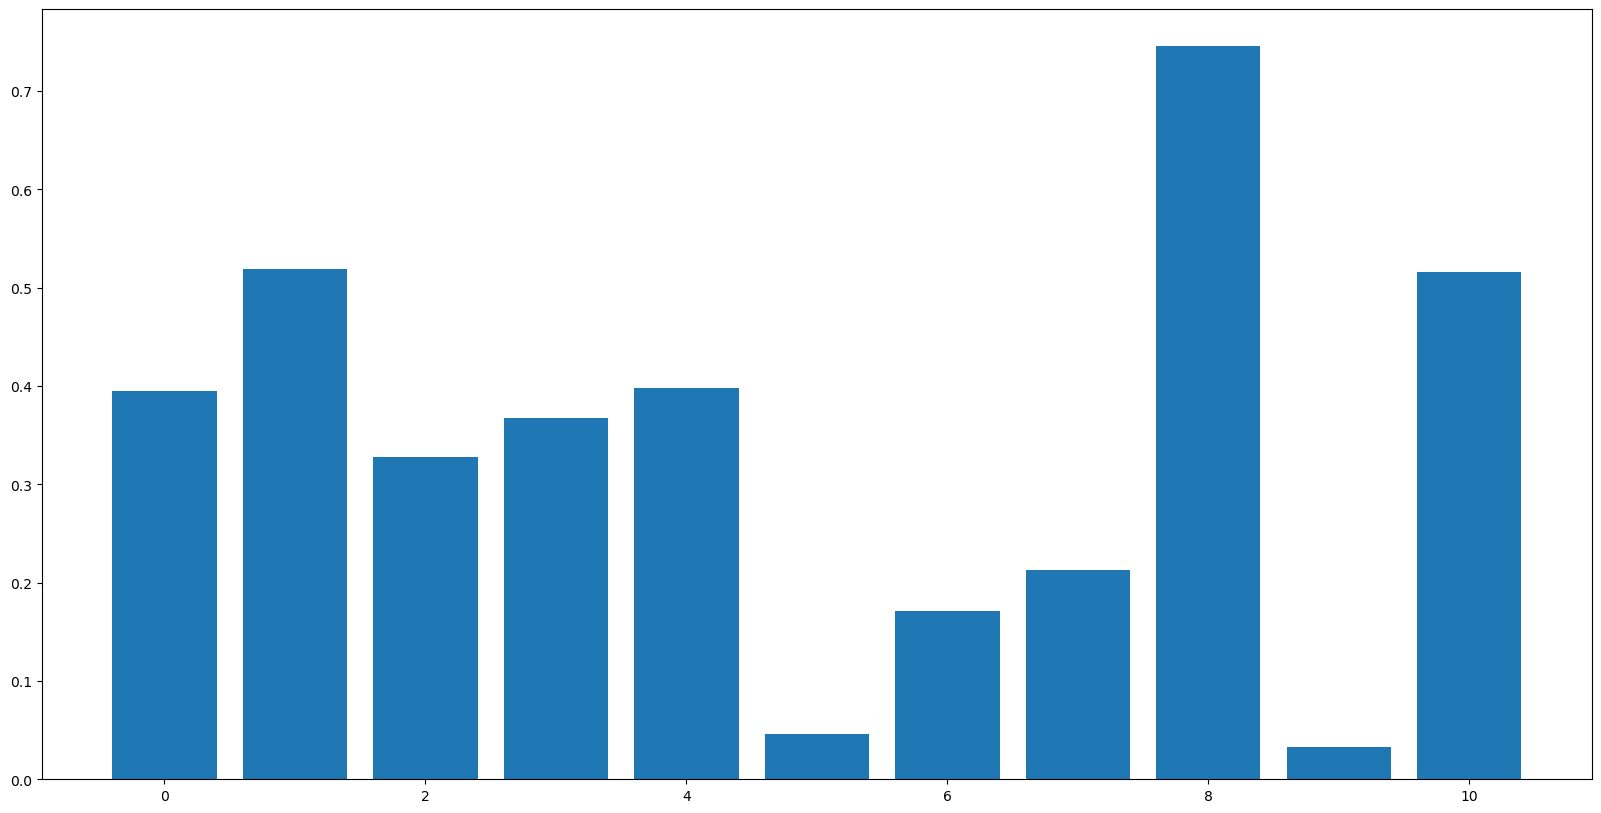

In [18]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, nim_all))
plt.show()

## plot using cool plotting stuff

In [52]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, height, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %d, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, height, layer_dims, padding, layer_padding)))

In [53]:
arr0 = [np.random.random((3,3)).tolist() for _ in range(6)]
arr1 = [np.random.random((3,3)).tolist() for _ in range(12)]
layers = [arr0, arr1]
edges = {
    "c1": [1,2,3,10]
}

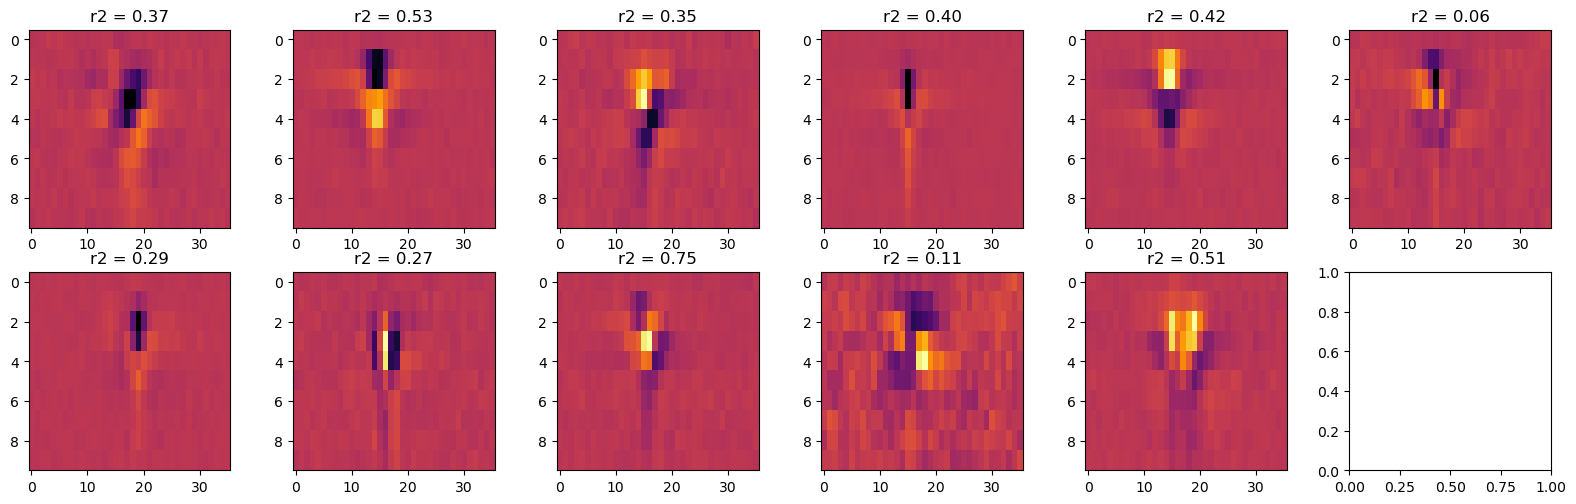

In [54]:
# plot cell weighted filters
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.networks[0].layers[1].get_weights()

ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    plt.imshow(rfield, cmap='inferno', aspect='auto', vmin=imin, vmax=imax)
    plt.title('r2 = ' + nim_r2s[c])
plt.show()


In [72]:
# plot cell weighted filters
hidden = nim_all.networks[0].layers[0].get_weights()
output = nim_all.networks[0].layers[1].get_weights()

rfields = []
for c in range(11):
    rfield = np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T
    imin = -np.max(abs(rfield))
    imax = np.max(abs(rfield))
    rfields.append(rfield.tolist())

len(rfields), np.array(rfields).shape

(11, (11, 10, 36))

In [68]:
hidden.shape, output.shape

((36, 10, 8), (8, 11))

In [ ]:
# plot it

In [59]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
# use exact dimensions to make sure it does work when not having floating point issues
draw_grids([rfields[:8]],
           {"c1": [1,2,3,10]},
           height=200, width=288,
           layer_dims={0:{'rows':2, 'cols':4}},
           padding=0,
           layer_padding=0)

<IPython.core.display.Javascript object>

In [88]:
# add layers
hidden.shape, output.shape, np.array(rfields).shape

((36, 10, 8), (8, 11), (11, 10, 36))

In [108]:
# get the hidden layer
# move the axes for the hidden layer to make it a list of boxes
print(np.swapaxes(hidden, 0,2).shape)

# get the output layer
# add an axis to the output layer to make the boxes 2d
print(np.expand_dims(output, 1).shape)

# turn them into a list of layers of boxes

(8, 10, 36)
(8, 1, 11)


In [113]:
draw_grids([np.swapaxes(hidden, 0,2).tolist(), np.expand_dims(output, 1).tolist()],
           {"c1": [1,2,3,10]},
           height=400, width=600,
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':1, 'cols':8}},
           padding=10,
           layer_padding=20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
# add edges
print(hidden.shape, output.shape)

((36, 10, 8), (8, 11))

In [131]:
# hidden layer reshaped to be a list of 8 boxes
# (36, 10, 8) --> (8, 10, 36)
hidden_boxes = np.swapaxes(hidden, 0,2)
# means of the weights of each neuron
# (8, 11) --> (1, 11) --> (1, 1, 11)
output_means = np.expand_dims(np.expand_dims(np.mean(output, axis=0), 1),1)

hidden_boxes.shape, output_means.shape

((8, 10, 36), (11, 1, 1))

In [140]:
starting_c = 2880 # terrible hack
weights = {}
# create the edge dictionary per neuron
for c in range(output.shape[1]): # for each neuron
    weights[c+starting_c] = {}
    i = 0 # start the id
    for b, w in enumerate(output[:,c]): # for each box & its weight
        for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
            for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                weights[c+starting_c][i] = w
                i += 1
                
weights.keys()

dict_keys([2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890])

In [206]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [207]:
# the layers to display
layers = [hidden_boxes.tolist(), output_means.tolist()]

draw_grids(layers,
           weights,
           height=400, width=600,
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':1, 'cols':11}},
           padding=10,
           layer_padding=20)

<IPython.core.display.Javascript object>

## test stuff

In [99]:
arr0 = [np.random.random((3,3)).tolist() for _ in range(6)]
arr2 = [np.random.random((3,3)).tolist() for _ in range(12)]
arr1 = [[[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]],
        [[0.1, 0.1, 0.1],
         [0.4, 0.5, 0.6],
         [0.4, 0.5, 0.6]]]

layers = [arr1, arr0, arr2]
edges = {
    "c1": [1,2,3,10]
}
layer_dims = {
    0: {'rows':2, 'cols':3},
    1: {'rows':2, 'cols':3},
    2: {'rows':3, 'cols':4}
}

draw_grids(layers,
           edges,
           height=500, width=400,
           layer_dims=layer_dims,
           padding=10,
           layer_padding=30)

<IPython.core.display.Javascript object>

In [ ]:
# [X] draw a grid of rectangles
# [X] make the rectangles selectable with the mouse
# [X] draw the grid based on what is passed in by the user
# [X] draw list of grids
# [X] pass in two sets of arrs and draw them one on top of the other
# [X] connect the selecting change in appearance of grids
# [X] highlight the corresponding weights when mousing over
# [X] make the rows and cols per layer, not the same for all layers
# TODO: convert the NDNT network to the layers and edges format needed for this API
# TODO: make it maintain aspect ratio when drawing different dimensions
#       NOTE: this is weird b/c a lot of the width/height incrementing is hardcoded 
#             and space is divided up into equal space partitions
#             Allowing different spaced partitions will likely require
#             refactoring the structure of each layer and the grids.
#             Not a bad idea, but possibly more work. Will have to think on it...
# TODO: fix the intensity scaling
# TODO: draw a fun curvy arrow between the two networks

## CNIM

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


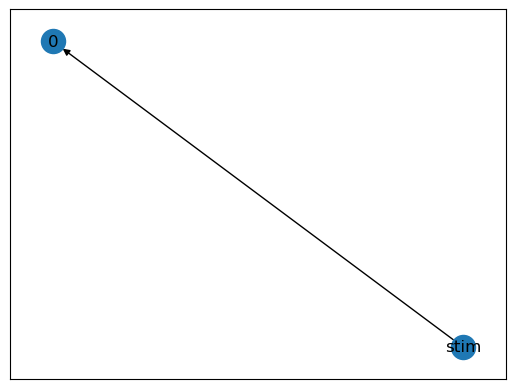

In [73]:
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=num_subs,
    norm_type=1,
    num_inh=num_subs//2, # this specifies that the first half of the subunits should be inhibitory (use "flipped" ReLU nonlinearity)
    filter_dims=fw, # dimensions of the Convolutional filter
    window='hamming', # apply a Hamming window to the filters to avoid edge artifacts 
    NLtype='relu',
    bias=False,
    initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Greg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True, # b/c it is the last layer
    pos_constraint=True, # this removes negative values created from the inhibitory subunits from the output
    initialize_center = True)

readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()

m.draw_model(cnim_all)

In [75]:
# cnim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
# LLs1 = cnim_all.eval_models(val_ds, null_adjusted=True)
# print(LLs1, np.mean(LLs1))
# 
# import pickle
# with open('cnim1.pickle', 'wb') as f:
#    pickle.dump(cnim_all, f)


GPU Available: True, GPU Used: True


Validating ver=3: 100%|██████████████████████████████████████████████████| 35/35 [00:00<00:00, 66.18it/s, val_loss=0.421]


Early stopping
Done fitting
  Fit complete: 37.828874588012695 sec elapsed


Eval models: 100%|██████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 104.49it/s]

[ 1.82872295e-01  5.92794180e-01  9.22882318e-01  2.63538122e-01
  4.00677323e-01  1.04685545e-01  1.18107796e-01  2.93750763e-02
 -5.72204590e-06  4.75957155e-01  1.05006695e-01] 0.2905355


In [78]:
cnim_all.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


### plot convolutional filters

In [100]:
cnim_all.networks[0].layers[1].output_dims, cnim_all.networks[0].layers[1]._output_dims

([11, 1, 1, 1], [11, 1, 1, 1])

In [112]:
# get the convolutional filters
hidden = cnim_all.networks[0].layers[0].get_weights()
output = cnim_all.networks[0].layers[1].get_weights()
data.stim_dims, '-->', hidden.shape, '-->', output.shape

([1, 36, 1, 10], '-->', (21, 10, 8), '-->', (8, 36, 11))

In [107]:
cnim_all.networks[0].layers

ModuleList(
  (0): ConvLayer(
    (NL): ReLU()
    (reg): Regularization(
      (reg_modules): ModuleList(
        (0): ConvReg()
        (1): InlineReg()
        (2): DiagonalReg()
      )
    )
  )
  (1): NDNLayer(
    (NL): Softplus(beta=1, threshold=20)
    (reg): Regularization(
      (reg_modules): ModuleList(
        (0): LocalityReg()
      )
    )
  )
)

In [ ]:
# https://theaisummer.com/receptive-field/
# https://distill.pub/2019/computing-receptive-fields/
# Article for how to calculate the receptive field of a CNN

# sum over the filters horizontally,
# so that we have 10 x 36 coming out of the first layer
# and 

ValueError: cannot reshape array of size 1680 into shape (360,8)

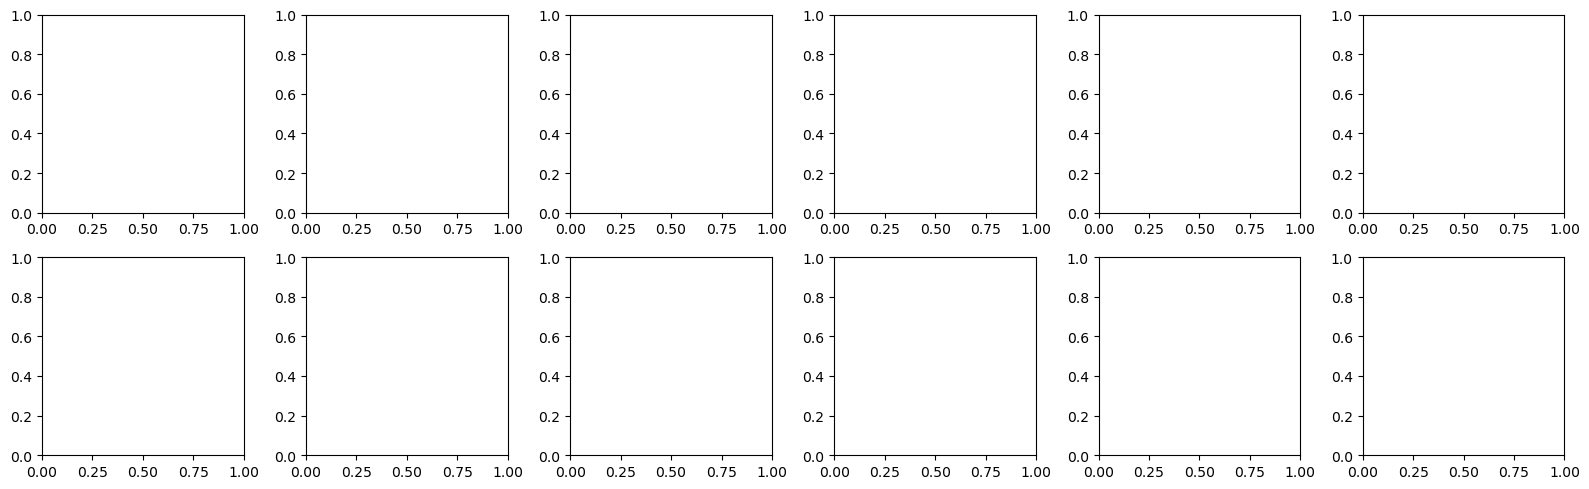

In [77]:
cnim_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim_all)]

# plot cell weighted filters
ss(2, 6)
for c in range(11):
    plt.subplot(2, 6, c+1)
    plt.imshow(np.sum((hidden.reshape(360,8) * output[:,c]).reshape(36,10,8), axis=2).T, cmap='inferno', aspect='auto')
    plt.title('r2 = ' + cnim_r2s[c])
plt.show()

## excitation/inhibition

(8, 36, 11)


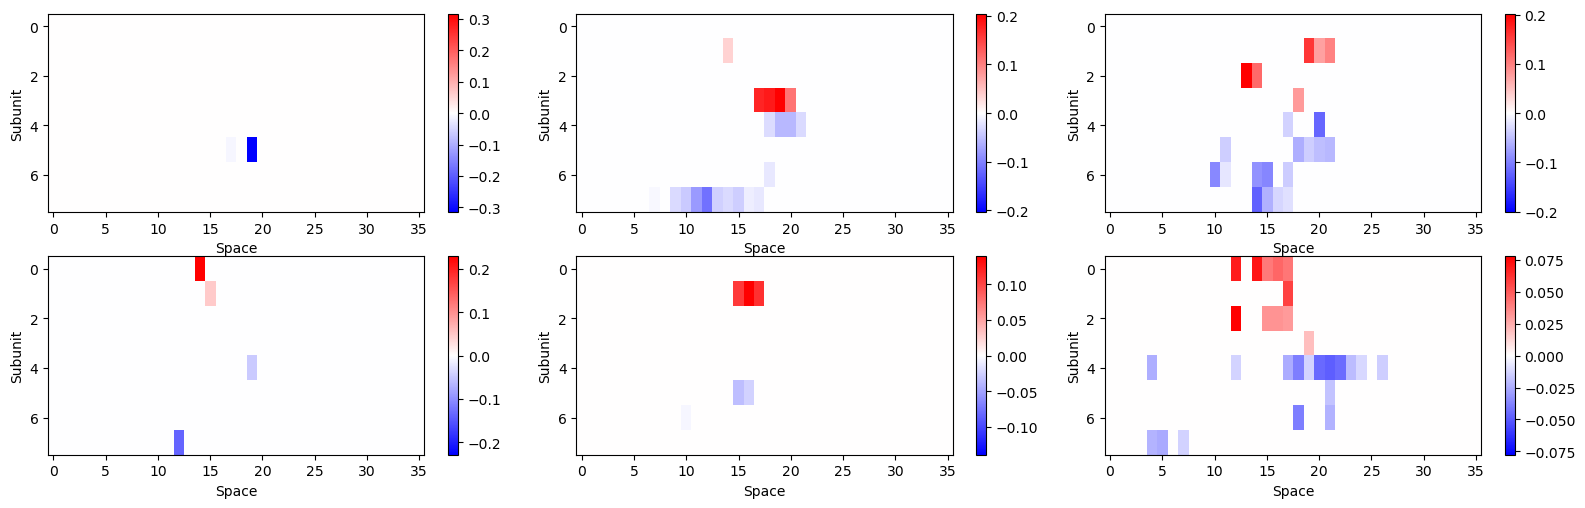

In [97]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
print(wR.shape)
wR[num_subs//2:, :] *= -1 # Make inhibitory weights less than zero
num_col = np.minimum(data.NC, 6)
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, num_col//2, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

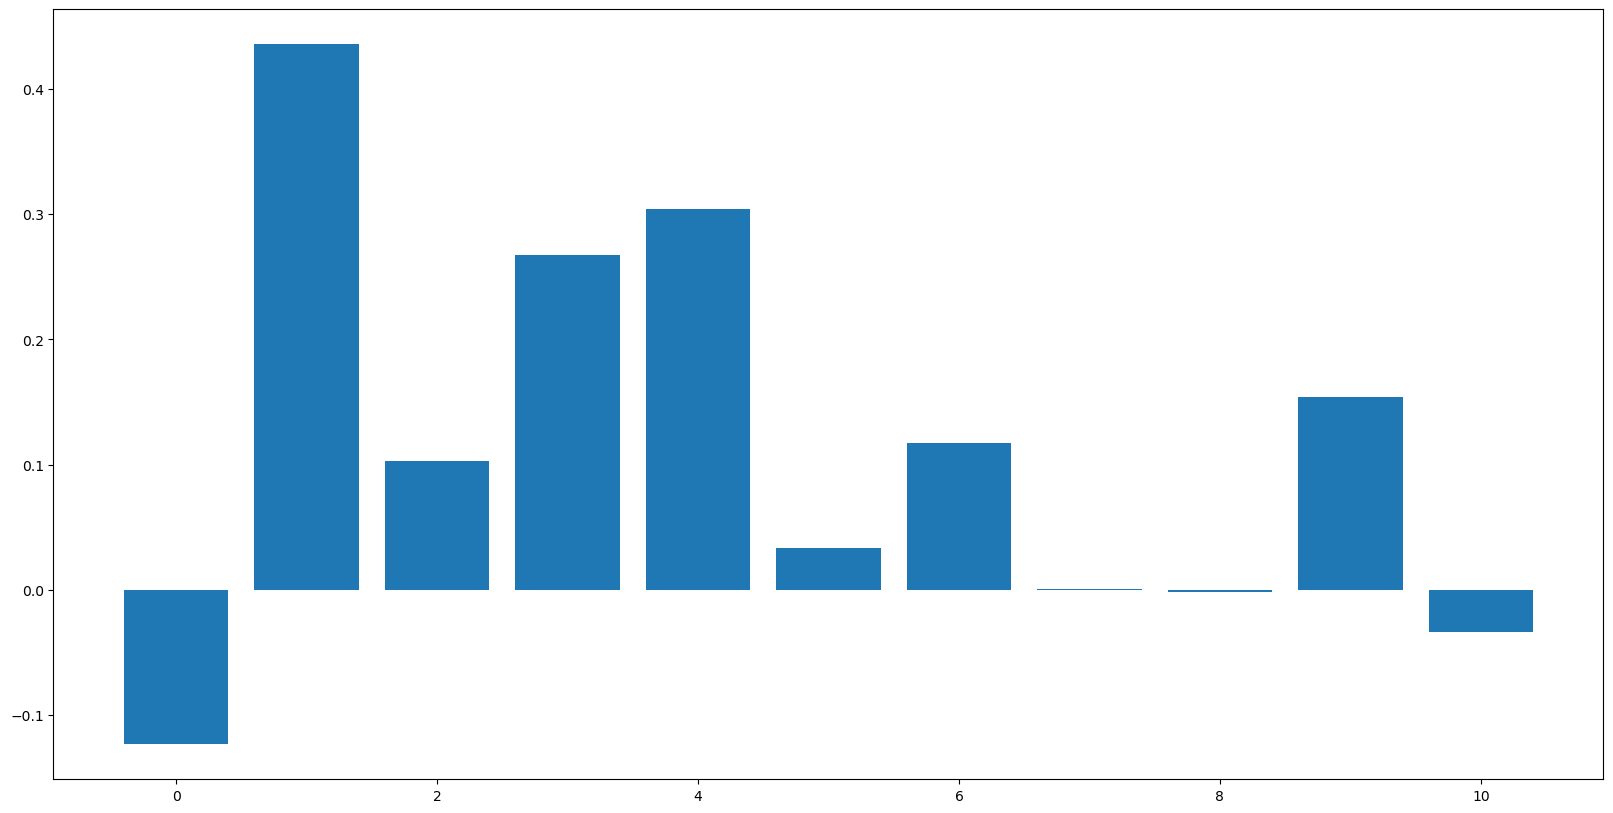

In [27]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, cnim_all))
plt.show()